This notebook puts together several steps for RadMC running from a Ramses simulation. For this notebook to run you will need :
- A functionning installation of radmc3d
- The ramses2radmc3d.py script
- For the latter to work, a functonning installation of Pymses
- The Convertions.py script
- The Files_to_copy directory or your version of the 4 files inside it (camera_wavelength_micron.inp, radmc3d.inp, stars.inp, wavelength_micron.inp)


In more details, RadMC needs to run : 
- Namelist file : (radmc3d.inp) : *to write/copy*
- Grid structure : (amr_grid.inp) : *written by ram2rad*
- Dust density : (dust_density.inp) : *written by ram2rad - modified by my conv script*
- Wavelength grid : (wavelength_micron.inp) : *to write/copy*
- Opacity :(dustopac.inp & dustkappa_*.inp/dustkapscatmat_*.inp) : *written by my conv script*
- Stars : (stars.inp) : *to write/copy from polaris info*
- Other radiation sources [optional]: (external_source.inp, heatsource.inp)


**Steps for radmc:**
- ramses2radmc for the grids
- write_radmc_separate_sizes_multiplt_species for the dust
- write/copy wavelength_micron
- write/copy camera_wavelength_micron
- write/copy stars
- write/copy radmc3d
- radmc3d mctherm (in .inp directory)
- radmc3d image loadlambda npix 800 sizeau 8000 incl -90 saccording to wanted parameters (800 nr_pixel, -90 inclination (WARNING DIFFERENT ANGLES DEFINITION THAN WITH POLARIS, opposite sign if I'm not mistaken), 8000au for dx dy 1.19678297e+15 m in polaris)

### Imports

In [7]:
import ramses2radmc3d
import subprocess
from matplotlib.colors import LogNorm
import numpy as np
%matplotlib widget

In [8]:
import sys
import os
from ramses2radmc3d import convert_ramses2radmc
sys.path.append(os.path.abspath("/drf/projets/capucine.new/mcarpine/RADMC")) #path were the Convertions script is 
# also add the path of where the ramses3radmc is if it's not in the same directory as the notebook.
import Convertions as co 
import matplotlib.pyplot as plt
from matplotlib import cm
from radmc3dPy import *

### Parameters

Here I use a lot my Convertions$^1$ script to import the dust properties. Either from dustem file (which has a summary of dust size distrib and properties in separate files), for which I have an output (my_dust) containing every information for each population (my_dust[i]). Or from polaris opacit file, and in this case I set up manually the distribution function for size distribution. For ex : (a**(-3.5))\*np.heaviside(a - amin,1)\* np.heaviside(amax - a,0)]. I let here a few examples that I used with different dust.

*1. Yes, I made a typo when I named the script, I meant Conversions but changing it now means that I have to change it in too many files and I can't find the courage to do so.*

In [9]:
# Ramses data
scat = True
datapath = "/drf/projets/capucine.new/mcarpine/ReviewPolarisvsRadMC/RadMC/DC_1"
num = 80
dust_to_gas = 0.005385523 #0.01

outpath =  "/drf/projets/capucine.new/mcarpine/ReviewPolarisvsRadMC_V2/RadMC/RADMC_DC_1_00080_TH2nosmadjust_onebin_scat/"
#For dust
path_d = '/drf/projets/capucine.new/mcarpine/ReviewPolarisvsRadMC_V2/Dust/Themis2/RadMC'
my_dust = co.auto_read_Dustem(path_d,path_d+'/GRAIN_2.DAT')
names = [my_dust[1][0],my_dust[2][0]]
df = [my_dust[1][2],my_dust[2][2]]
distrib = [my_dust[1][1],my_dust[2][1]]

a_min,a_max = [my_dust[1][6][0],my_dust[2][6][0]],[my_dust[1][6][1],my_dust[2][6][1]]
proportion = [0.375,0.625]
n_bins = [1,1] #n_bins=[10,12]


# # Simple dust
# outpath =  "/drf/projets/capucine.new/mcarpine/ReviewPolarisvsRadMC_V2/RadMC/RADMC_DC_1_00080_TH2nosmadjust_onebin_simple/"
# path_d = '/drf/projets/capucine.new/mcarpine/ReviewPolarisvsRadMC_V2/Dust/Themis2/RadMC'
# my_dust = co.auto_read_Dustem(path_d,path_d+'/GRAIN_Simple.DAT')
# names = [my_dust[0][0]]
# df = [my_dust[0][2]]
# print(df[0][np.logical_and(df[0].index.get_level_values('aeff')>1e-7,df[0].index.get_level_values('wave')>3e-7)])
# distrib = [my_dust[0][1]]
# a_min,a_max = [my_dust[0][6][0]],[my_dust[0][6][1]]
# proportion = [1]
# n_bins = [1] #n_bins=[10,12]


# # Simple dust fiducial
# outpath =  "/drf/projets/capucine.new/mcarpine/ReviewPolarisvsRadMC_V2/RadMC/RADMC_DC_1_00080_TH2nosmadjust_onebin_simple_fiducial/"
# path_d = '/drf/projets/capucine.new/mcarpine/ReviewPolarisvsRadMC_V2/Dust/Fiducial/silicate_oblate_homogenised.dat'
# path_d = '/drf/projets/capucine.new/mcarpine/Polaris/Modified_dust/silicate_oblate_a_all.dat'
# names = ["silicate_oblate"]
# df = [co.read_Q_Polaris(path_d)]
# df[0]['dens'] = 3800
# # print(df[0][np.logical_and(df[0].index.get_level_values('aeff')>1e-7,df[0].index.get_level_values('wave')>3e-7)])
# distrib = [lambda a: (a**(-3.5))*np.heaviside(a - 1.0e-08,1)* np.heaviside(2.1e-08 - a,0)]
# a_min,a_max = [1.0e-08],[2.1e-8]
# proportion = [1]
# n_bins = [1] #n_bins=[10,12]
# For image 

npix = 800#800
sizeau = 8000
dpc = 7.71419395e+18/3.085677581e16
path_fits = outpath+'image.fits'

starpos = [3.3881627500856327e10, 1.2303378480752747e11, -7.259610992590149e10 ]
htspot = [[2e14,0,2e14],[3e14,0,2e14],[2e14,0,3e14],[2e14,0,4e14]]

/drf/projets/capucine.new/mcarpine/RADMC/Convertions.py:326: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_aeff = pd.read_table(filepath,delim_whitespace=True,engine='python', index_col=False,names =[i for i in range(n_sizes)],skiprows = gr_start[0]+1,header=None,skipfooter = len(lines)-(gr_start[0]+2))
/drf/projets/capucine.new/mcarpine/RADMC/Convertions.py:328: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_dens = pd.read_table(filepath,delim_whitespace=True,engine='python', index_col=False,names =[i for i in range(n_sizes)],skiprows = gr_start[0]+2,header=None,skipfooter = len(lines)-(gr_start[0]+3))
/drf/projets/capucine.new/mcarpine/RADMC/Convertions.py:330: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use `

### 1. Convert Ramses grid to RadMC grid

In [10]:
convert_ramses2radmc(datapath, num, dust_to_gas, outpath,starpos)


/local/home/mc276490/.conda/envs/Pymses_env/lib/python3.10/site-packages/pymses/__init__.py
Ramses input:     /drf/projets/capucine.new/mcarpine/ReviewPolarisvsRadMC/RadMC/DC_1output_00080
Output for RADMC: amr_grid.inp, dust_density.inp

Loading RAMSES data from: 
 /drf/projets/capucine.new/mcarpine/ReviewPolarisvsRadMC/RadMC/DC_1output_00080
/drf/projets/capucine.new/mcarpine/ReviewPolarisvsRadMC/RadMC/DC_1output_00080


folder:  /drf/projets/capucine.new/mcarpine/ReviewPolarisvsRadMC/RadMC/DC_1 80 


/drf/projets/capucine.new/mcarpine/ReviewPolarisvsRadMC/RadMC/DC_1/output_00080/hydro_file_descriptor.txt
  -> Checking endianness for output #80...
  -> Computing hilbert minimal domain description for output #80...
{'ncpu': 32, 'ndim': 3, 'levelmin': 6, 'levelmax': 14, 'ngridmax': 100000, 'nstep_coarse': 7800, 'boxlen': 0.0765621193260999, 'time': 0.000924428758870582, 'aexp': 1.0, 'H0': 1.0, 'omega_m': 1.0, 'omega_l': 0.0, 'omega_k': 0.0, 'omega_b': 0.0450000017881393, 'unit_length':

### 2. Copy files that *a priori* don't need any modification

For my simus I always use the same parameters but you may need to change some things in those files:
- camera_wavelength_micron.inp : the wavelength at which you want outputs
- radmc3d.inp : main simulation parameters, for instance turning on or off the scattering (see documentation of radMC for more details), number of photons etc. I kept most parameters to default. I have here a simple choice for scattering or no scattering.
- stars.inp : star radius, mass, position and spectrum. I chose to use BB spectrum so I only give the temperautre with negative sign (see doc)
- wavelength_micron.inp : discrete wavelength points for RT computations.

In [11]:
if scat :
    os.system(f"cp -r /drf/projets/capucine.new/mcarpine/ReviewPolarisvsRadMC_V2/RadMC/Files_to_copy_scat/. {outpath}")
else:
    os.system(f"cp -r /drf/projets/capucine.new/mcarpine/ReviewPolarisvsRadMC_V2/RadMC/Files_to_copy/. {outpath}")


### 3. Write the dust opacity files

RadMC 3D does not provide a simple way to treat a dust population, so we must do the avergaing ourselves. From the dust size distribution and the dust opacity/efficiencies according to their size, we create the average (on dust cross sections, then we go back to the quantity we want : opacity, efficieny, etc.)

$$\langle C_\mathrm{ext}\rangle = \frac{ \int_{a_\mathrm{min}}^{a_\mathrm{max}}C_\mathrm{ext}(a)n(a)\mathrm{d}a }{\int_{a_\mathrm{min}}^{a_\mathrm{max}}n(a)\mathrm{d}a} $$

The python file Convertions has many functions that permit to juggle between dust popertiees files of Dustem, Polaris, RadMC, ADDA outputs, DDScat outputs, and it creates here the RadMC input file.

This routine will write the dust opacity file, but also modify the *dust density* file if several dust species are defined (carbon and silicate for example). In this case indeed, we need to duplicate the dust density for each dust species (multiplied by the species proportion), so the density table is appended with the additional dust species.

In [1]:
co.write_radmc_separate_sizes_multiplt_species(outpath,names,df,distrib,proportion,n_bins,a_min,a_max)

NameError: name 'co' is not defined

### 4. Run RaMC3D

In [13]:
subprocess.run(["radmc3d","mctherm"],cwd=outpath)

  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
                          VERSION 2.0                            
                                                                 
                (c) 2008-2023 Cornelis Dullemond                 
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                    dullemond@uni-heidelberg.de                  
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, follow the   
                     RADMC-3D code on github                     
             https://github.com/dullemond/radmc3d-2.0            
                                                                 
       

CompletedProcess(args=['radmc3d', 'mctherm'], returncode=0)

### 5. RadMC image creation (second step)

In [14]:
subprocess.run(["radmc3d",f"image loadlambda npix {npix} sizeau {sizeau} incl 90"],cwd=outpath)

  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
                          VERSION 2.0                            
                                                                 
                (c) 2008-2023 Cornelis Dullemond                 
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                    dullemond@uni-heidelberg.de                  
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, follow the   
                     RADMC-3D code on github                     
             https://github.com/dullemond/radmc3d-2.0            
                                                                 
       

CompletedProcess(args=['radmc3d', 'image loadlambda npix 800 sizeau 8000 incl 90'], returncode=0)

### 6. We use functions from radmcd3dPy to read the image and create a fits file.

Reading /drf/projets/capucine.new/mcarpine/ReviewPolarisvsRadMC_V2/RadMC/RADMC_DC_1_00080_TH2nosmadjust_onebin_scat/image.out


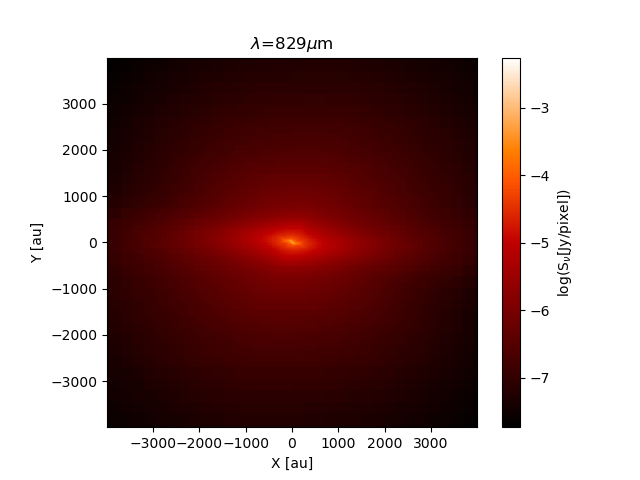

{'implot': <matplotlib.image.AxesImage at 0x7f1dfb8bafe0>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x7f1df2c522c0>}

In [15]:
im=image.readImage(outpath+"image.out")
image.plotImage(im,au=True,cmap=cm.gist_heat,ifreq=0,log=True,bunit='jy/pixel',dpc=dpc) # distance from polaris

In [16]:
im.writeFits(fname=path_fits, dpc=dpc)

### 7.  Now other utilitary for temperature or density outputs 

#### Temperature (radmc subbox)

In [11]:
nx,ny,nz=512,1,512
prop='temperature'
subprocess.run(["radmc3d",f"subbox_dust_{prop} subbox_nxyz {nx} {ny} {nz} subbox_xyz01 -1.179057e+17 1.179057e+17 0 0 -1.179057e+17 1.179057e+17"],cwd=outpath)


  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
                          VERSION 2.0                            
                                                                 
                (c) 2008-2023 Cornelis Dullemond                 
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                    dullemond@uni-heidelberg.de                  
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, follow the   
                     RADMC-3D code on github                     
             https://github.com/dullemond/radmc3d-2.0            
                                                                 
       

CompletedProcess(args=['radmc3d', 'subbox_dust_temperature subbox_nxyz 512 1 512 subbox_xyz01 -1.179057e+17 1.179057e+17 0 0 -1.179057e+17 1.179057e+17'], returncode=0)

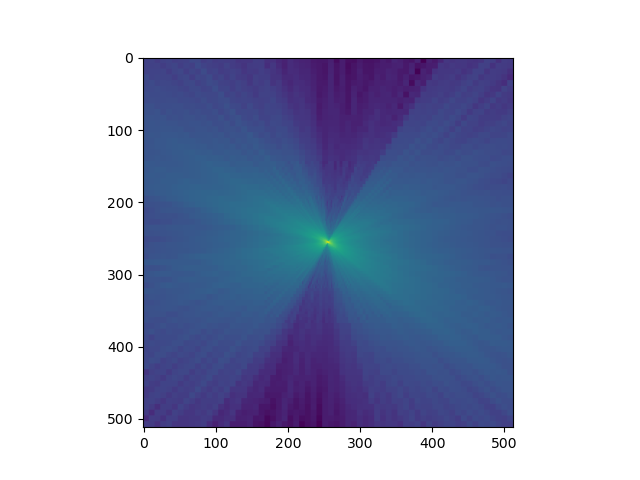

In [12]:
grid_sub = np.loadtxt(outpath+'dust_'+prop+'_subbox.out',skiprows=7)

grid = np.zeros((nx, ny, nz))

for i_z in range(nz):
    for i_y in range(ny):
        for i_x in range(nx):
            grid[i_x,i_y,i_z] = grid_sub[ny*nx*i_z + nx*i_y + i_x]
            # at the end of this nested loop, the index will be ny*nx*(nz-1) + nx*(ny-1) + nx-1 = nx*ny*nz - 1

plt.figure()
plt.imshow(grid[:,0,:], norm = LogNorm())
plt.show()

#### Density (radmc subbox)

In [13]:
nx,ny,nz=512,1,512
dx = 4.6056899907107e14
xi,xf = -1.1790566376219432e17,1.1790566376219432e17 # left of first pixel and right of last pixel
prop='density'
subprocess.run(["radmc3d",f"subbox_dust_{prop} subbox_nxyz {nx} {ny} {nz} subbox_xyz01 {xi} {xf} 0 0 {xi} {xf}"],cwd=outpath)
# subprocess.run(["radmc3d",f"subbox_dust_{prop} subbox_nxyz {nx} {ny} {nz} subbox_xyz01 -1.17675379262658e+17 1.17675379262658e+17 0 0 -1.17675379262658e+17 1.17675379262658e+17"],cwd=outpath)



  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
                          VERSION 2.0                            
                                                                 
                (c) 2008-2023 Cornelis Dullemond                 
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                    dullemond@uni-heidelberg.de                  
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, follow the   
                     RADMC-3D code on github                     
             https://github.com/dullemond/radmc3d-2.0            
                                                                 
       

CompletedProcess(args=['radmc3d', 'subbox_dust_density subbox_nxyz 512 1 512 subbox_xyz01 -1.1790566376219432e+17 1.1790566376219432e+17 0 0 -1.1790566376219432e+17 1.1790566376219432e+17'], returncode=0)

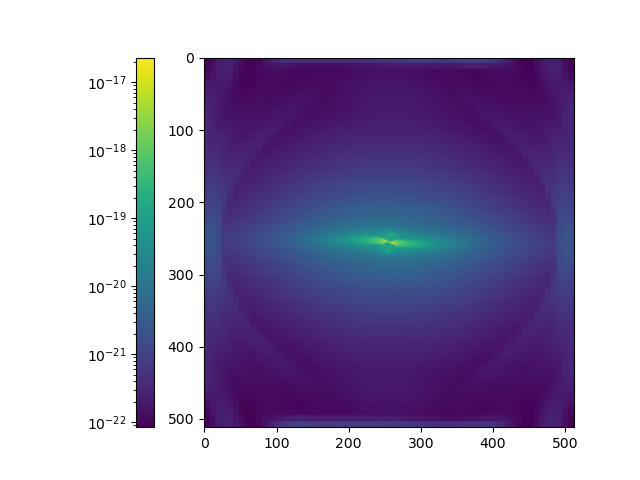

In [14]:
grid_sub = np.loadtxt(outpath+'dust_'+prop+'_subbox.out',skiprows=7)

grid = np.zeros((nx, ny, nz))

for i_z in range(nz):
    for i_y in range(ny):
        for i_x in range(nx):
            grid[i_x,i_y,i_z] = grid_sub[ny*nx*i_z + nx*i_y + i_x]
            # at the end of this nested loop, the index will be ny*nx*(nz-1) + nx*(ny-1) + nx-1 = nx*ny*nz - 1

plt.figure()
img = plt.imshow(np.rot90(grid[:,0,:],k=1), norm = LogNorm())
plt.colorbar(img, ax=plt.gca(), orientation='vertical',location='left')
img.set_clim(np.min(grid[grid > 1.1e-99]),np.max(grid[grid > 1.1e-99]))
plt.show()

# plt.figure()
# img= plt.imshow((np.rot90(grid[:,0,:],k=1)-np.rot90(grid[:,0,:],k=3))/np.rot90(grid[:,0,:],k=1)*100,cmap = 'seismic',origin ='lower')
# img.set_clim(-100,100)
# plt.gcf().colorbar(img)
# plt.show()